In [1]:
import numpy as np
from scipy.stats import multivariate_normal
import sim_framework as sf 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.tri as tri
from scipy.interpolate import griddata
from scipy.ndimage import gaussian_filter
import matplotlib.path as mpath


# Helper functions

In [2]:
def create_contour_plot(x, y, z, xlabel, ylabel, title, legend_label):
    """
    Create a smoothed contour plot.

    Parameters:
    - x: Array-like sequence of x-coordinates (e.g., heritability).
    - y: Array-like sequence of y-coordinates (e.g., phenotypic correlation).
    - z: Array-like sequence of values at the x, y coordinates (e.g., fraction of variants recovered).
    - xlabel: Label for the x-axis.
    - ylabel: Label for the y-axis.
    - title: Title of the plot.
    - legend_label: Label for the color bar legend.
    """
    
    # Create grid coordinates
    xi = np.linspace(min(x), max(x), 75)  # 100 points for smoothness can be adjusted
    yi = np.linspace(min(y), max(y), 75)  # 100 points for smoothness can be adjusted
    Xi, Yi = np.meshgrid(xi, yi)
    
    # Interpolate unstructured D-dimensional data to the points on the grid
    Zi = griddata((x, y), z, (Xi, Yi), method='linear')  # Other methods include 'linear' and 'nearest'

    # Create the contour plot using the denser grid and interpolated data
    plt.figure(figsize=(8, 6))
    contour = plt.contourf(
        Xi,
        Yi,
        Zi,
        levels=500,  # Modify the levels for more or fewer contours
        cmap='viridis'
    )

    # Add a color bar with the specified legend label
    plt.colorbar(contour)

    # Set the provided axis labels and title
    plt.xlabel(xlabel, fontsize = 15)
    plt.ylabel(ylabel, fontsize = 15)
    plt.title(title, fontsize = 15)

    # Show the plot
    plt.show()


# Effects of heritability of biomarkers and biomarker-phenotype correlation on causal variant recovery

In [4]:
N, n, m, k = 10000, 100, 1, 0
n_B, n_P, n_BP = 50, 0, 0
p = 0.25
sigma_P, sigma_BP = 1, 1
sigma_epsilon_B, sigma_epsilon_P = 1, 1
correlations = np.arange(0.01,0.75,0.01)

sigma_B = np.logspace(-3,3,len(correlations))
env_variance = np.array([0.01]) 

x = []
y = []
z = []

for i in range(len(correlations)):
    correlation_matrix = np.reshape(np.array([correlations[i].tolist()]*m),(1,m))
    for j in range(len(sigma_B)):
        
        
        
        results = sf.simulate_phenotypes_and_biomarkers_with_correlations(N, n, m, k, n_B, n_P, n_BP, p,
                                                                  sigma_B[j], sigma_P, sigma_BP,
                                                                  sigma_epsilon_B, sigma_epsilon_P)
        B, _, h2_B, _, _, _, _, G, causal_indices_B, _, E_B, _, _, _  = results
        
        B = (B - np.mean(B))/np.std(B)
        y += [np.mean(h2_B).tolist()]
        
        P = sf.simulate_downstream_phenotypes(B, correlation_matrix, env_variance)
        
        x += [np.corrcoef(B.flatten(),P.flatten())[0,1]**2]
        
        results2 = sf.run_gwas_return_metrics(P, G, causal_indices_B.T, None)
        _, _, TPR, _, _, _ = results2 
        z += [TPR]
        
x = np.array(x)
y = np.array(y).flatten()
z = np.array(z)

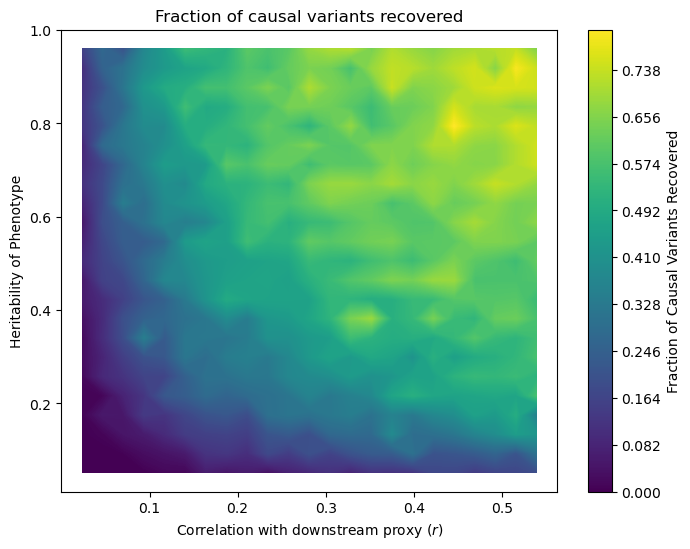

In [73]:
ylabel='Heritability of Phenotype'
xlabel='Correlation with downstream proxy ($r$)'
title='Fraction of causal variants recovered'
legend_label='Fraction of Causal Variants Recovered'

create_contour_plot(x, y, z, xlabel, ylabel, title, legend_label)

# Averaging over 10 runs to reduce randomness 

In [8]:
N, n, m, k = 10000, 100, 1, 0
n_B, n_P, n_BP = 50, 0, 0
p = 0.25
sigma_P, sigma_BP = 1, 1
sigma_epsilon_B, sigma_epsilon_P = 1, 1
correlations = np.arange(0.01, 0.75, 0.05)

sigma_B = np.logspace(-3, 3, len(correlations))
env_variance = np.array([0.01])
n_rep = 10  # Number of repetitions

# Initialize arrays to store average results
x_avg = []
y_avg = []
z_avg = []

for i in range(len(correlations)):
    correlation_matrix = np.reshape(np.array([correlations[i].tolist()] * m), (1, m))
    for j in range(len(sigma_B)):

        # Initialize variables to store the results of each repetition
        xs = []
        ys = []
        zs = []

        for rep in range(n_rep):
            # Perform the simulation
            results = sf.simulate_phenotypes_and_biomarkers_with_correlations(N, n, m, k, n_B, n_P, n_BP, p,
                                                                              sigma_B[j], sigma_P, sigma_BP,
                                                                              sigma_epsilon_B, sigma_epsilon_P)

            B, _, h2_B, _, _, _, _, G, causal_indices_B, _, E_B, _, _, _ = results

            B = (B - np.mean(B)) / np.std(B)
            ys.append(np.mean(h2_B).tolist())

            P = sf.simulate_downstream_phenotypes(B, correlation_matrix, env_variance)

            xs.append(np.corrcoef(B.flatten(), P.flatten())[0, 1] ** 2)

            results2 = sf.run_gwas_return_metrics(P, G, causal_indices_B.T, None)
            _, _, TPR, _, _, _ = results2
            zs.append(TPR)

        # Store the average of the results
        x_avg.append(np.mean(xs))
        y_avg.append(np.mean(ys))
        z_avg.append(np.mean(zs))

# Convert lists to NumPy arrays if needed
x_avg = np.array(x_avg)
y_avg = np.array(y_avg)
z_avg = np.array(z_avg)

# Now you can use x_avg, y_avg, z_avg for plotting or further analysis


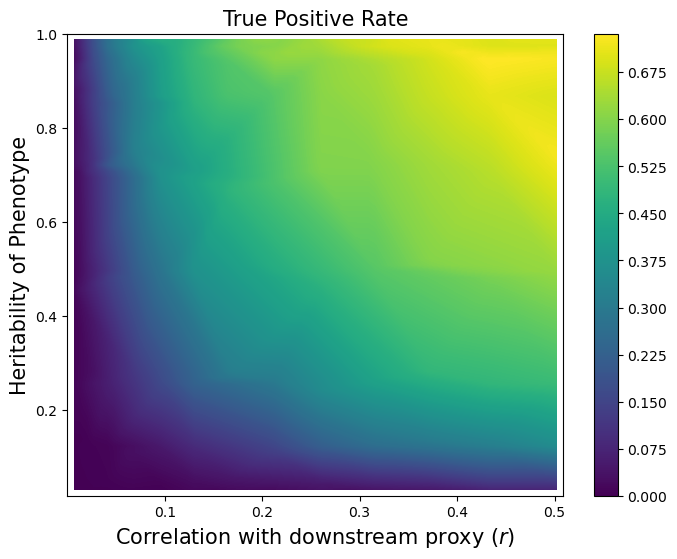

In [9]:
ylabel='Heritability of Phenotype'
xlabel='Correlation with downstream proxy ($r$)'
title='True Positive Rate'
legend_label='True Positive Rate'

create_contour_plot(x_avg, y_avg, z_avg, xlabel, ylabel, title, legend_label)